# Rainband Lightning Threshold Analysis
In this notebook, we define the threshold for what constitutes a "lightning burst" in the rainband of a tropical cyclone. 

### How do we define a burst of lightning?
We define a lightning burst based off the number of lightning instances in a 30-minute time bin.

We start by evaluating each tropical cyclone (TC) individually, and then look at basin-level threshold trends and distributions. Below are the different basins:
* ATL - Atlantic Ocean basin
* CPAC - Central Pacific basin
* EPAC - Eastern Pacific basin
* IO - Indian Ocean basin
* SHEM - Southern Hemisphere basin
* WPAC - Western North Pacific basin

## Code
### Import Libraries and Files
Let's start by importing necessary libraries and files. The rainband dataset is created in the `rainband_data.ipynb` notebook as `rainband_shear_timebin_joined.csv`. This file can be found in the `data_pipeline/data/` directory of the repository.

In [15]:
import pandas as pd
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
from scipy.stats import median_abs_deviation
import matplotlib.patches as mpatches
from lightning_threshold_functions import *

In [16]:
rainband_data = pd.read_csv("../data_pipeline/data/rainband_shear_timebin_joined.csv")
rainband_data = pl.from_pandas(rainband_data)

In [17]:
rainband_data.head()

shape: (5, 20)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ time_bin  ┆ shear_qua ┆ storm_cod ┆ lightning ┆ … ┆ 24_hour_k ┆ 24_hour_p ┆ TC_Catego ┆ Intensif │
│ ---       ┆ d         ┆ e         ┆ _count    ┆   ┆ nots_diff ┆ ressure_d ┆ ry        ┆ ication_ │
│ str       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ iff       ┆ ---       ┆ Category │
│           ┆ str       ┆ str       ┆ i64       ┆   ┆ f64       ┆ ---       ┆ str       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆           ┆ f64       ┆           ┆ str      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 2010-06-2 ┆ DL        ┆ ATL_10_1  ┆ 0         ┆ … ┆ 10.0      ┆ -1.0      ┆ Unidentif ┆ Intensif │
│ 0         ┆           ┆           ┆           ┆   ┆           ┆           ┆ ied       ┆ ying     │
│ 18:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2010-06-2 ┆ DR        ┆ ATL_10_1  ┆ 0         ┆ … ┆ 10.0      ┆ -1.0      ┆ Unidentif ┆ Intensif │
│ 0         ┆           ┆           ┆           ┆   ┆           ┆           ┆ ied       ┆ ying     │
│ 18:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2010-06-2 ┆ UL        ┆ ATL_10_1  ┆ 0         ┆ … ┆ 10.0      ┆ -1.0      ┆ Unidentif ┆ Intensif │
│ 0         ┆           ┆           ┆           ┆   ┆           ┆           ┆ ied       ┆ ying     │
│ 18:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2010-06-2 ┆ UR        ┆ ATL_10_1  ┆ 0         ┆ … ┆ 10.0      ┆ -1.0      ┆ Unidentif ┆ Intensif │
│ 0         ┆           ┆           ┆           ┆   ┆           ┆           ┆ ied       ┆ ying     │
│ 18:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2010-06-2 ┆ DL        ┆ ATL_10_1  ┆ 0         ┆ … ┆ 10.0      ┆ -1.0      ┆ Unidentif ┆ Intensif │
│ 0         ┆           ┆           ┆           ┆   ┆           ┆           ┆ ied       ┆ ying     │
│ 18:30:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [18]:
# import data from csv file
rainband_data = rainband_data.with_columns(
    pl.col("time_bin").str.strptime(pl.Datetime).alias("time_bin"),
    pl.col("storm_code").str.extract(r"^(.*?)_", 1).alias("basin"), # Parse basin from storm code
    pl.col("lightning_count").log1p().alias("log_lightning_count"), # Log transform the counts
    pl.when(pl.col("pressure") == 0)
    .then(None)  # Replace 0 with None -> 0 is not possible, treat these as null but don't remove row bc the wind speed value is valid
    .otherwise(pl.col("pressure"))
    .alias("pressure")  # Keep the column name as "pressure"
)
rainband_data = rainband_data.with_columns(
    pl.when(pl.col("TC_Category") == "Unidentified")
    .then(pl.lit("0")) # Replace "unidentified" with 0 for current category
    .otherwise(pl.col("TC_Category"))
    .alias("TC_Category")
)
rainband_data = rainband_data.rename({"Intensification_Category":"Intensification_Category_5", "TC_Category":"Current_Category"})
rainband_data.head()

shape: (5, 21)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ time_bin  ┆ shear_qua ┆ storm_cod ┆ lightning ┆ … ┆ 24_hour_p ┆ Current_C ┆ Intensifi ┆ log_ligh │
│ ---       ┆ d         ┆ e         ┆ _count    ┆   ┆ ressure_d ┆ ategory   ┆ cation_Ca ┆ tning_co │
│ datetime[ ┆ ---       ┆ ---       ┆ ---       ┆   ┆ iff       ┆ ---       ┆ tegory_5  ┆ unt      │
│ μs]       ┆ str       ┆ str       ┆ i64       ┆   ┆ ---       ┆ str       ┆ ---       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆ f64       ┆           ┆ str       ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 2010-06-2 ┆ DL        ┆ ATL_10_1  ┆ 0         ┆ … ┆ -1.0      ┆ 0         ┆ Intensify ┆ 0.0      │
│ 0         ┆           ┆           ┆           ┆   ┆           ┆           ┆ ing       ┆          │
│ 18:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2010-06-2 ┆ DR        ┆ ATL_10_1  ┆ 0         ┆ … ┆ -1.0      ┆ 0         ┆ Intensify ┆ 0.0      │
│ 0         ┆           ┆           ┆           ┆   ┆           ┆           ┆ ing       ┆          │
│ 18:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2010-06-2 ┆ UL        ┆ ATL_10_1  ┆ 0         ┆ … ┆ -1.0      ┆ 0         ┆ Intensify ┆ 0.0      │
│ 0         ┆           ┆           ┆           ┆   ┆           ┆           ┆ ing       ┆          │
│ 18:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2010-06-2 ┆ UR        ┆ ATL_10_1  ┆ 0         ┆ … ┆ -1.0      ┆ 0         ┆ Intensify ┆ 0.0      │
│ 0         ┆           ┆           ┆           ┆   ┆           ┆           ┆ ing       ┆          │
│ 18:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2010-06-2 ┆ DL        ┆ ATL_10_1  ┆ 0         ┆ … ┆ -1.0      ┆ 0         ┆ Intensify ┆ 0.0      │
│ 0         ┆           ┆           ┆           ┆   ┆           ┆           ┆ ing       ┆          │
│ 18:30:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

We map the intensification bins into 3, combining the rapidly weakening and weakening bins, and the rapidly intensifying and intensifying bins.

In [19]:
# Mapping intensification bins into 3 category instead of 5
category_mapping = {
    "Rapidly Weakening": "Weakening",
    "Weakening": "Weakening",
    "Neutral": "Neutral",
    "Intensifying": "Intensifying",
    "Rapidly Intensifying": "Intensifying"
}

# Apply mapping to create new column
rainband_data = rainband_data.with_columns(
    rainband_data["Intensification_Category_5"].replace(category_mapping).alias("Intensification_Category_3")
)

rainband_data.head()

shape: (5, 22)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ time_bin  ┆ shear_qua ┆ storm_cod ┆ lightning ┆ … ┆ Current_C ┆ Intensifi ┆ log_light ┆ Intensif │
│ ---       ┆ d         ┆ e         ┆ _count    ┆   ┆ ategory   ┆ cation_Ca ┆ ning_coun ┆ ication_ │
│ datetime[ ┆ ---       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ tegory_5  ┆ t         ┆ Category │
│ μs]       ┆ str       ┆ str       ┆ i64       ┆   ┆ str       ┆ ---       ┆ ---       ┆ _3       │
│           ┆           ┆           ┆           ┆   ┆           ┆ str       ┆ f64       ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ str      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 2010-06-2 ┆ DL        ┆ ATL_10_1  ┆ 0         ┆ … ┆ 0         ┆ Intensify ┆ 0.0       ┆ Intensif │
│ 0         ┆           ┆           ┆           ┆   ┆           ┆ ing       ┆           ┆ ying     │
│ 18:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2010-06-2 ┆ DR        ┆ ATL_10_1  ┆ 0         ┆ … ┆ 0         ┆ Intensify ┆ 0.0       ┆ Intensif │
│ 0         ┆           ┆           ┆           ┆   ┆           ┆ ing       ┆           ┆ ying     │
│ 18:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2010-06-2 ┆ UL        ┆ ATL_10_1  ┆ 0         ┆ … ┆ 0         ┆ Intensify ┆ 0.0       ┆ Intensif │
│ 0         ┆           ┆           ┆           ┆   ┆           ┆ ing       ┆           ┆ ying     │
│ 18:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2010-06-2 ┆ UR        ┆ ATL_10_1  ┆ 0         ┆ … ┆ 0         ┆ Intensify ┆ 0.0       ┆ Intensif │
│ 0         ┆           ┆           ┆           ┆   ┆           ┆ ing       ┆           ┆ ying     │
│ 18:00:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 2010-06-2 ┆ DL        ┆ ATL_10_1  ┆ 0         ┆ … ┆ 0         ┆ Intensify ┆ 0.0       ┆ Intensif │
│ 0         ┆           ┆           ┆           ┆   ┆           ┆ ing       ┆           ┆ ying     │
│ 18:30:00  ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [20]:
# Create dataframe for filtering later
storm_names = rainband_data[["storm_code", "storm_name"]].unique()

-------------------------

### Individual TC Analysis
We start by applying the 6 different thresholds to each TC individually, where we evaluate burst thresholds in comparison to a TC's own lightning activity for time bins associated with wind speeds greater than or equal to 40 knots. We do not group by shear quadrant when evaluating burst thresholds, but we will look at the shear quadrant associated with identified bursts. 

We start by filtering out data associated with wind speeds less than 40 knots.

In [21]:
# Filter out data where wind is less than 40 knots for threshold analysis
analysis_data = rainband_data.filter(pl.col("knots") >= 40)
# Convert polars dataframe to pandas for application of functions
pd_data = analysis_data.to_pandas()

We then apply the functions to the data, including timebins with no lightning activity (0 lightning count).

In [22]:
# Apply functions to data, including bins with 0 lightning
bursts_w_0 = apply_individual_thresholds(pd_data)

tc_summary_w_0 = create_tc_summary(bursts_w_0, rainband=True)
tc_summary_w_0.head(10)

storm_code shear_quad  mad1_bursts  mad2_bursts  mad1_threshold  \
0   ATL_10_1         DL          121          121             0.0   
1   ATL_10_1         DR           92           92             0.0   
2   ATL_10_1         UL           99           99             0.0   
3   ATL_10_1         UR           77           77             0.0   
4  ATL_10_11         DL          144          144             0.0   
5  ATL_10_11         DR          289          289             0.0   
6  ATL_10_11         UL           96           96             0.0   
7  ATL_10_11         UR          250          250             0.0   
8  ATL_10_12         DL           73           73             0.0   
9  ATL_10_12         DR          127          127             0.0   

   mad2_threshold  iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  \
0             0.0           22            0        4.969813        6.212267   
1             0.0            4            0        4.969813        6.212267   
2             0.0            2            0        4.969813        6.212267   
3             0.0            5            0        4.969813        6.212267   
4             0.0           40           23        2.197225        2.746531   
5             0.0          176          139        2.197225        2.746531   
6             0.0           27           12        2.197225        2.746531   
7             0.0          119           68        2.197225        2.746531   
8             0.0           73           73        0.000000        0.000000   
9             0.0          127          127        0.000000        0.000000   

   ...  logn2_bursts  logn1_threshold  logn2_threshold  total_bins  mad1_prop  \
0  ...             0         4.559965         6.217398         211      57.35   
1  ...             0         4.559965         6.217398         211      43.60   
2  ...             0         4.559965         6.217398         211      46.92   
3  ...             0         4.559965         6.217398         211      36.49   
4  ...             0         3.203989         4.435583         565      25.49   
5  ...            23         3.203989         4.435583         565      51.15   
6  ...             0         3.203989         4.435583         565      16.99   
7  ...             4         3.203989         4.435583         565      44.25   
8  ...             8         1.401047         1.997657         390      18.72   
9  ...            35         1.401047         1.997657         390      32.56   

   mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
0      57.35      10.43       0.00       13.27        0.00  
1      43.60       1.90       0.00        2.37        0.00  
2      46.92       0.95       0.00        1.90        0.00  
3      36.49       2.37       0.00        2.37        0.00  
4      25.49       7.08       4.07        2.12        0.00  
5      51.15      31.15      24.60       18.23        4.07  
6      16.99       4.78       2.12        0.35        0.00  
7      44.25      21.06      12.04        8.14        0.71  
8      18.72      18.72      18.72        5.38        2.05  
9      32.56      32.56      32.56       13.85        8.97  

[10 rows x 21 columns]

In [23]:
# Get mean threshold value for each of the 6 options
tc_summary_w_0_mean = tc_summary_w_0.drop(columns=("storm_code")).mean()
print(tc_summary_w_0_mean[["mad1_threshold", "mad2_threshold", "iqr1_threshold", "iqr2_threshold", "logn1_threshold", "logn2_threshold"]])
# Get median threshold value for each of the 6 options
tc_summary_w_0_median = tc_summary_w_0.drop(columns=("storm_code")).median()
print(tc_summary_w_0_median[["mad1_threshold", "mad2_threshold", "iqr1_threshold", "iqr2_threshold", "logn1_threshold", "logn2_threshold"]])

TypeError: Could not convert ['DLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULURDLDRULUR'] to numeric

We can see that the threshold values are all very low, meaning that any lightning activity is likely to be flagged as a burst. We plot one TC below to look at a specific example. This can be expected, as we know that many of the timebins have no lightning activity, therefore skewing the threshold lower.

<Figure size 1000x500 with 0 Axes>

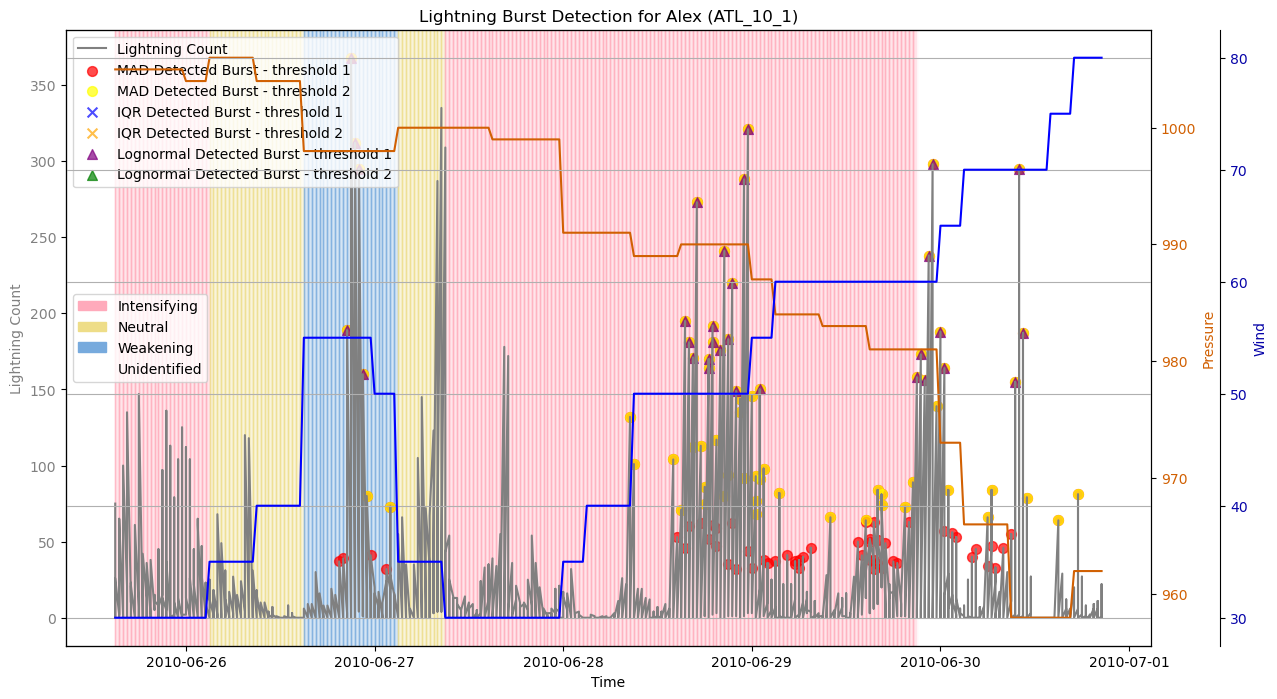

<Figure size 1000x500 with 0 Axes>

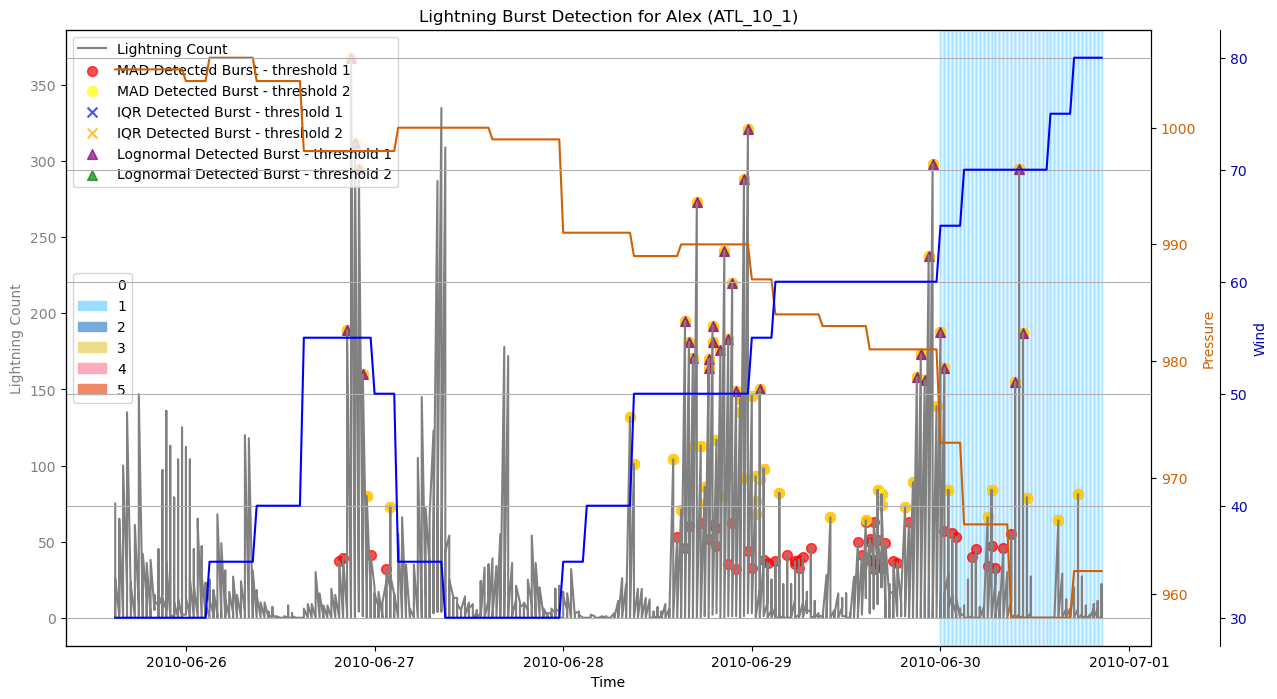

storm_code  mad1_bursts  mad2_bursts  mad1_threshold  mad2_threshold  \
0   ATL_10_1          121           68        3.465736        4.158883   

   iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  logn1_bursts  \
0            0            0        5.914525        7.393156            31   

   logn2_bursts  logn1_threshold  logn2_threshold  total_bins  mad1_prop  \
0             0         5.000153         6.718335         672      18.01   

   mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
0      10.12        0.0        0.0        4.61         0.0

In [ ]:
# ATL_10_1 with 0 in the analysis
cyclone_id = 'ATL_10_1'

plot_tc(cyclone_id, bursts_w_0, storm_names, rainband_data, "i3")
plot_tc(cyclone_id, bursts_w_0, storm_names, rainband_data, "c5")
# Print the summary for this storm
tc_summary_w_0[tc_summary_w_0["storm_code"] == cyclone_id]

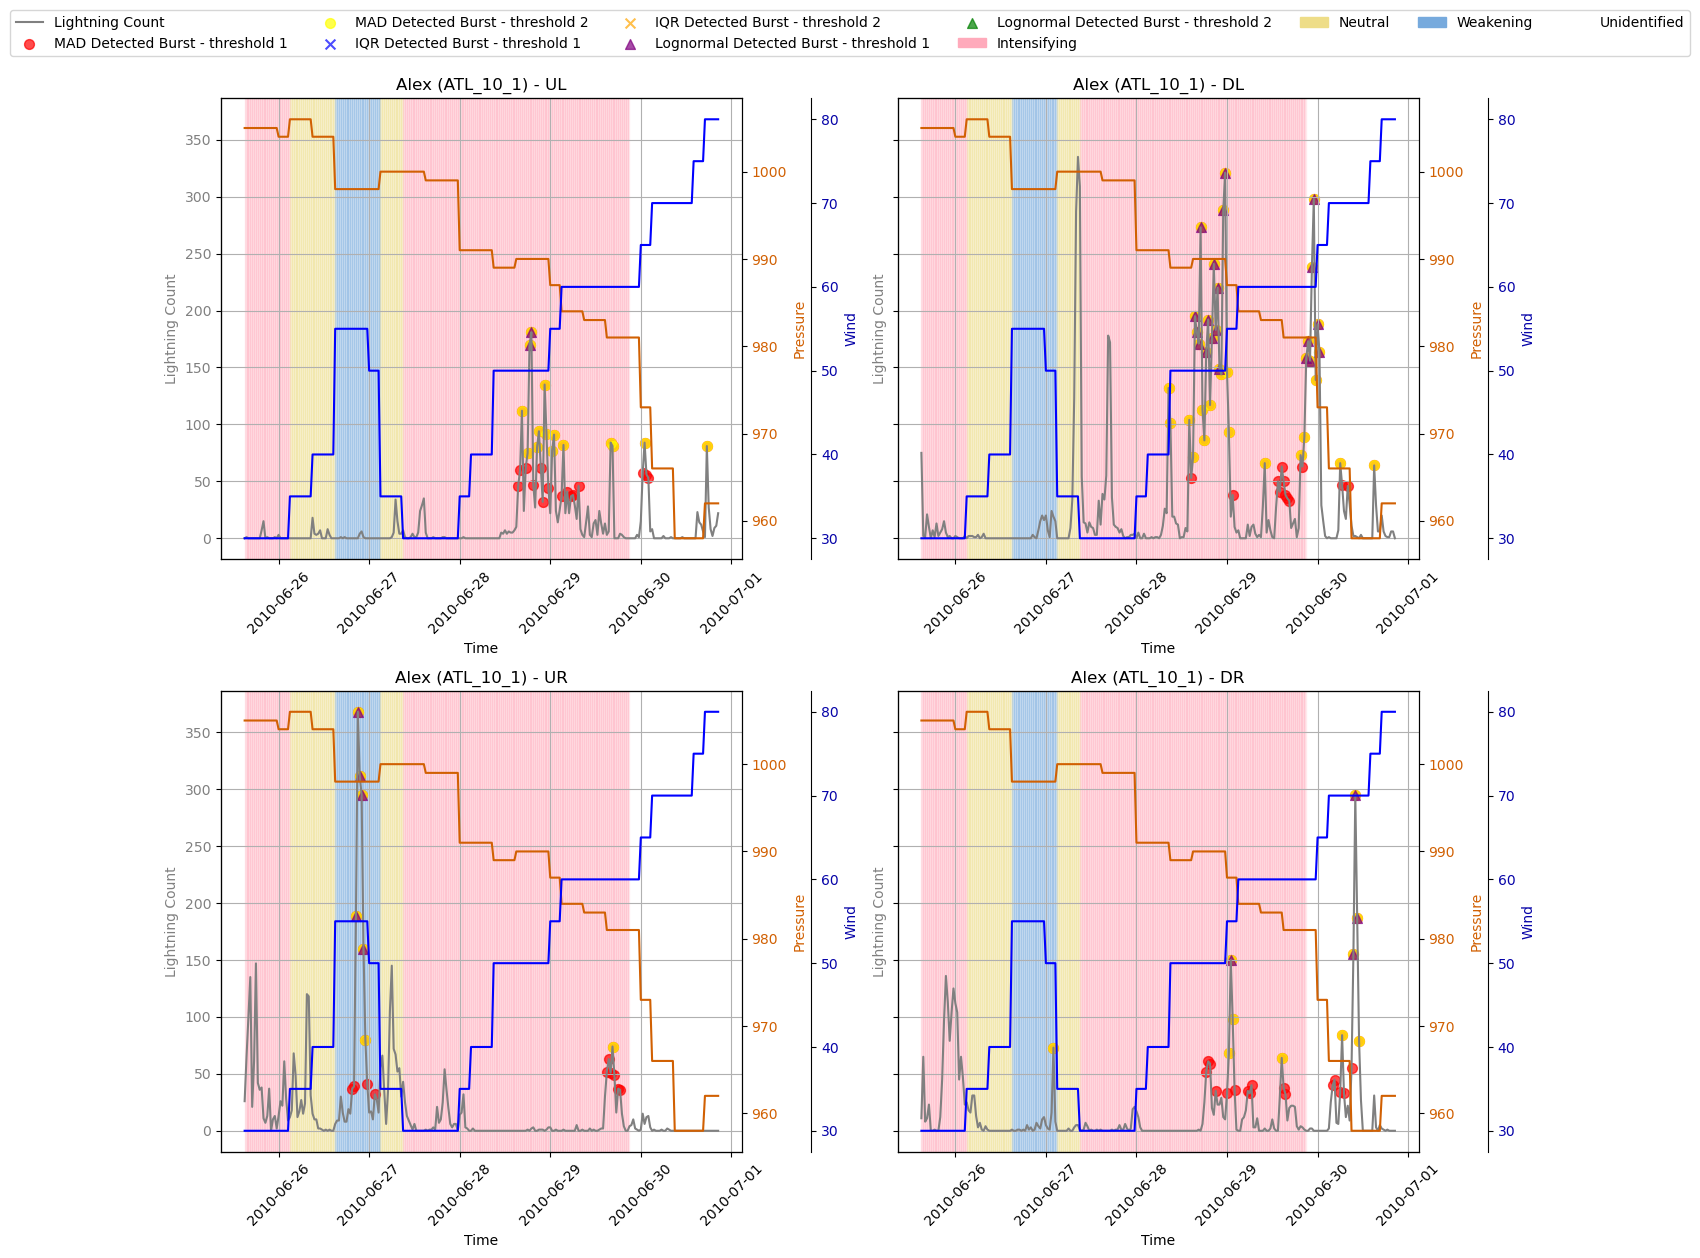

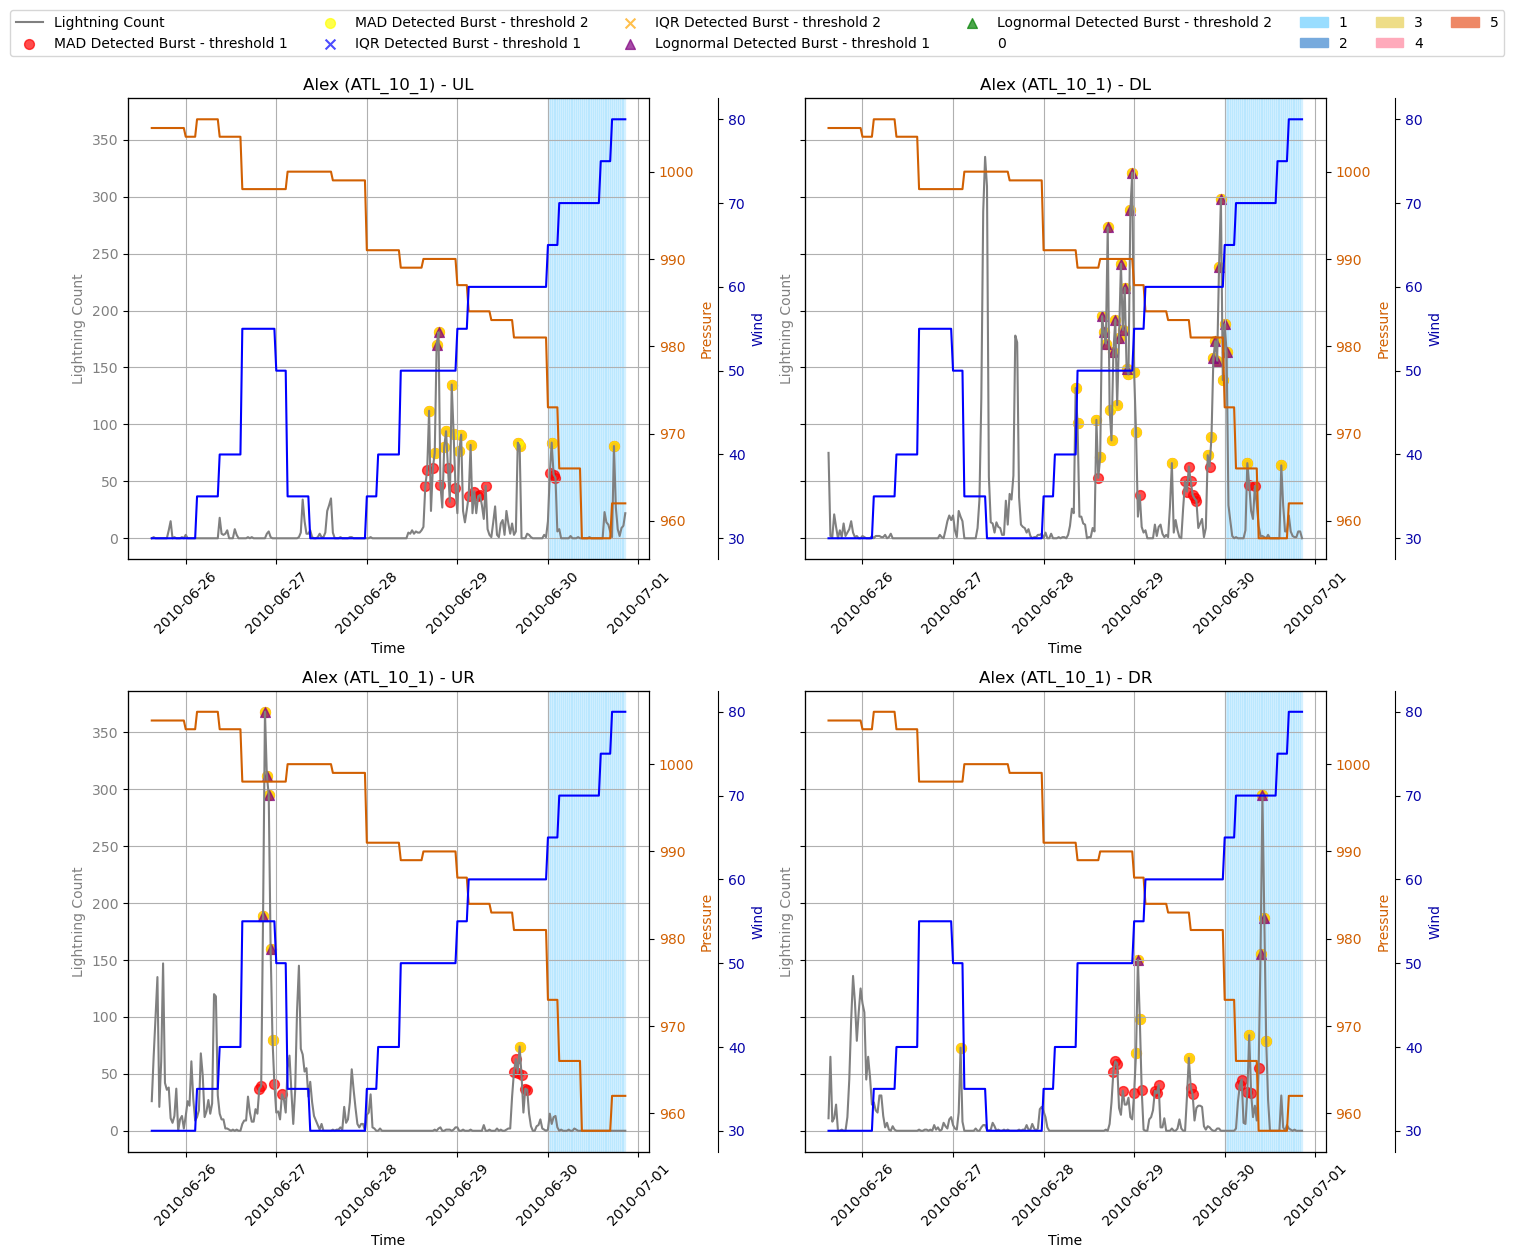

In [ ]:
# ATL_10_1 by shear quadrants
plot_tc_quadrants(cyclone_id, bursts_w_0, storm_names, rainband_data, "i3")
plot_tc_quadrants(cyclone_id, bursts_w_0, storm_names, rainband_data, "c5")

We then apply the threshold evaluation to the dataset without timebins with 0 lightning count. This slightly alters our definition of a lightning burst - we compare each set of lightning events to other nonzero lightning events. This should bring up the threshold and bring down the percent of timebins flagged as a burst.

In [ ]:
# Apply functions to data(exclude 0 lightning count)
pd_data_drop0 = pd_data[pd_data['lightning_count'] != 0]

bursts = apply_individual_thresholds(pd_data_drop0)

tc_summary = create_tc_summary(bursts, rainband=True)
tc_summary = pd.merge(storm_names.to_pandas(), tc_summary, on="storm_code")
tc_summary.head(10)

storm_code storm_name shear_quad  mad1_bursts  mad2_bursts  mad1_threshold  \
0   ATL_12_14     Nadine         DL           17           10        2.720473   
1   ATL_12_14     Nadine         DR           29           17        2.720473   
2   ATL_12_14     Nadine         UL            2            1        2.720473   
3   ATL_12_14     Nadine         UR            7            2        2.720473   
4   WPAC_16_6       Nida         DL            0            0        7.284821   
5   WPAC_16_6       Nida         DR            0            0        7.284821   
6   WPAC_16_6       Nida         UL            0            0        7.284821   
7   WPAC_16_6       Nida         UR            0            0        7.284821   
8  EPAC_11_13    Kenneth         DL            0            0        5.274601   
9  EPAC_11_13    Kenneth         DR            2            0        5.274601   

   mad2_threshold  iqr1_bursts  iqr2_bursts  iqr1_threshold  ...  \
0        3.125938            0            0        3.701302  ...   
1        3.125938            5            2        3.701302  ...   
2        3.125938            1            0        3.701302  ...   
3        3.125938            0            0        3.701302  ...   
4        8.383433            0            0        6.068756  ...   
5        8.383433           11            0        6.068756  ...   
6        8.383433            0            0        6.068756  ...   
7        8.383433            0            0        6.068756  ...   
8        6.190892            0            0        5.087596  ...   
9        6.190892            3            0        5.087596  ...   

   logn2_bursts  logn1_threshold  logn2_threshold  total_bins  mad1_prop  \
0             0         3.383470         4.305096         142      11.97   
1             2         3.383470         4.305096         167      17.37   
2             0         3.383470         4.305096          37       5.41   
3             0         3.383470         4.305096          73       9.59   
4             0         5.842836         7.281282          82       0.00   
5             0         5.842836         7.281282         113       0.00   
6             0         5.842836         7.281282          72       0.00   
7             0         5.842836         7.281282          89       0.00   
8             0         5.063922         6.533383          10       0.00   
9             0         5.063922         6.533383          56       3.57   

   mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
0       7.04       0.00        0.0        4.23         0.0  
1      10.18       2.99        1.2        7.19         1.2  
2       2.70       2.70        0.0        2.70         0.0  
3       2.74       0.00        0.0        1.37         0.0  
4       0.00       0.00        0.0        0.00         0.0  
5       0.00       9.73        0.0       11.50         0.0  
6       0.00       0.00        0.0        0.00         0.0  
7       0.00       0.00        0.0        0.00         0.0  
8       0.00       0.00        0.0        0.00         0.0  
9       0.00       5.36        0.0        7.14         0.0  

[10 rows x 22 columns]

<Figure size 1000x500 with 0 Axes>

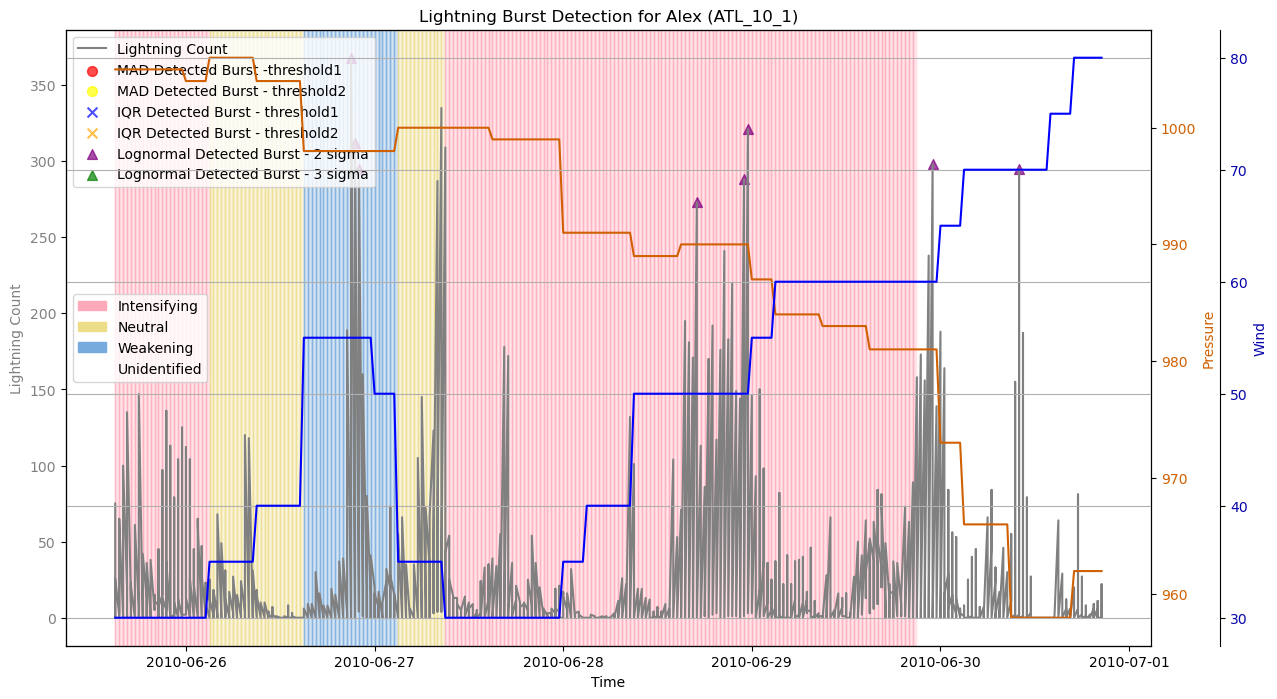

<Figure size 1000x500 with 0 Axes>

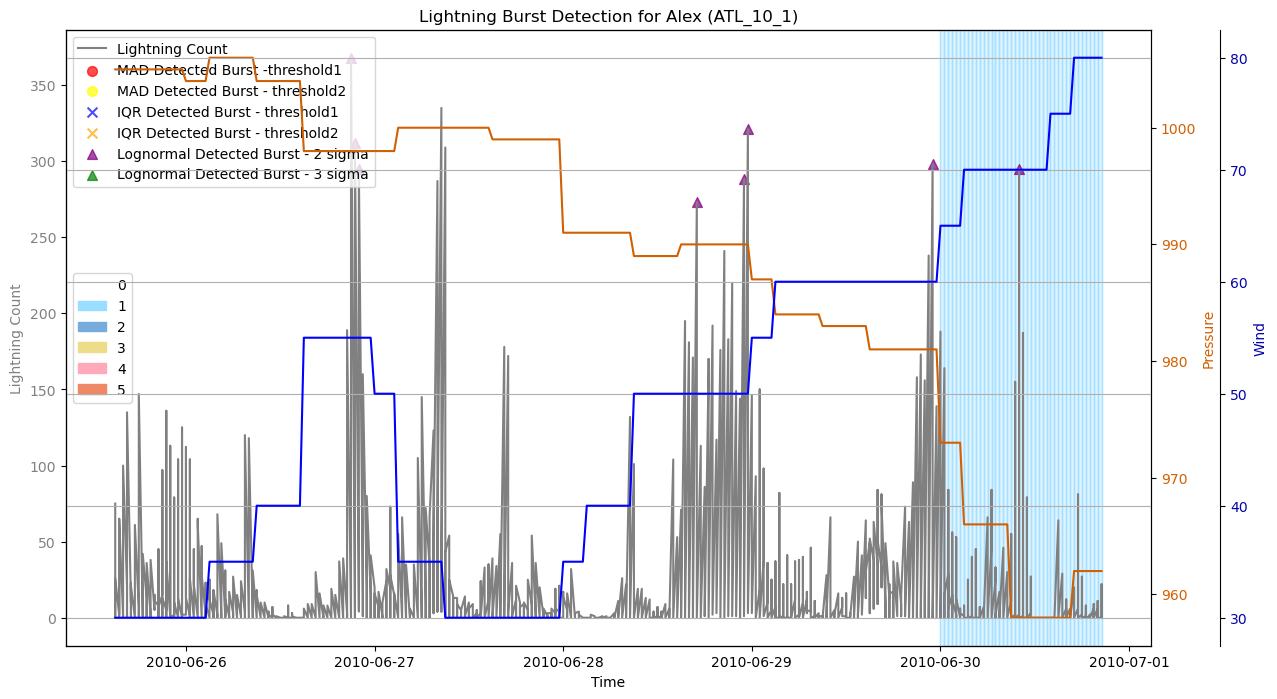

storm_code storm_name  mad1_bursts  mad2_bursts  mad1_threshold  \
189   ATL_10_1       Alex            0            0        7.397394   

     mad2_threshold  iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  \
189        8.586978            0            0         6.04085        7.204489   

     ...  logn2_bursts  logn1_threshold  logn2_threshold  total_bins  \
189  ...             0          5.54689         6.969608         389   

     mad1_prop  mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
189        0.0        0.0        0.0        0.0        2.06         0.0  

[1 rows x 21 columns]

In [ ]:
# ATL_10_1 without 0 in threshold calculation
cyclone_id = 'ATL_10_1'
plot_tc(cyclone_id, bursts, storm_names, rainband_data, "i3")
plot_tc(cyclone_id, bursts, storm_names, rainband_data, "c5")
# Print the summary for this storm
tc_summary[tc_summary["storm_code"] == cyclone_id]

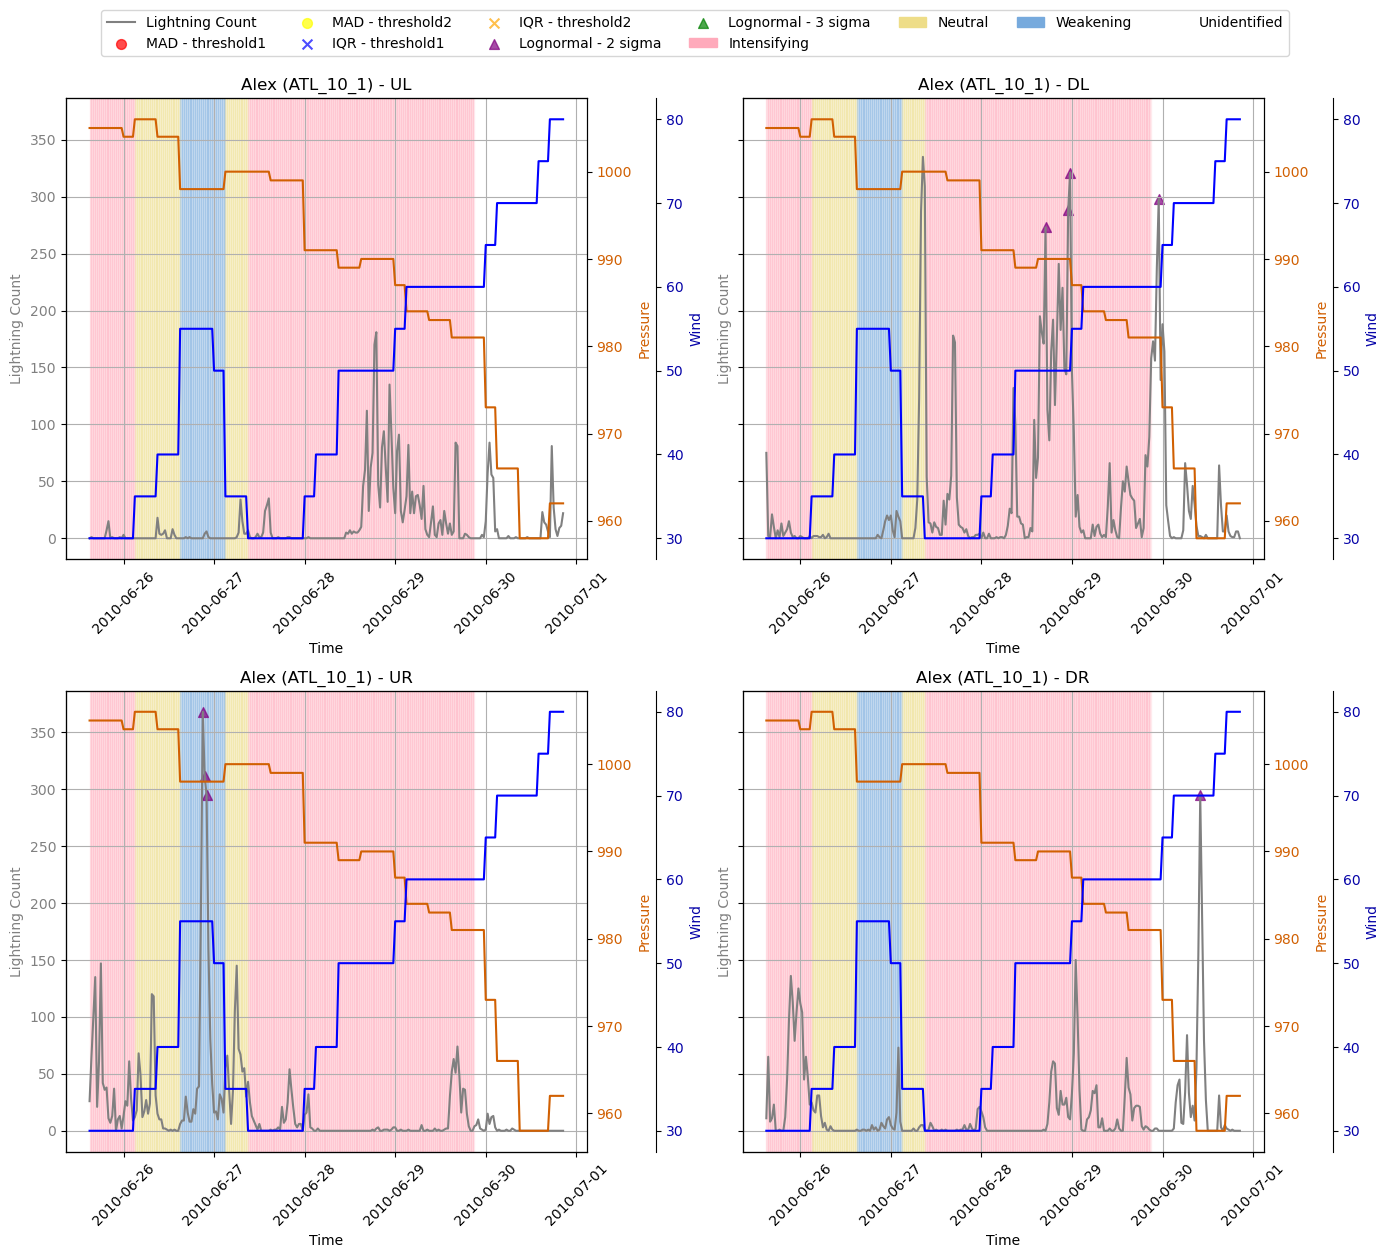

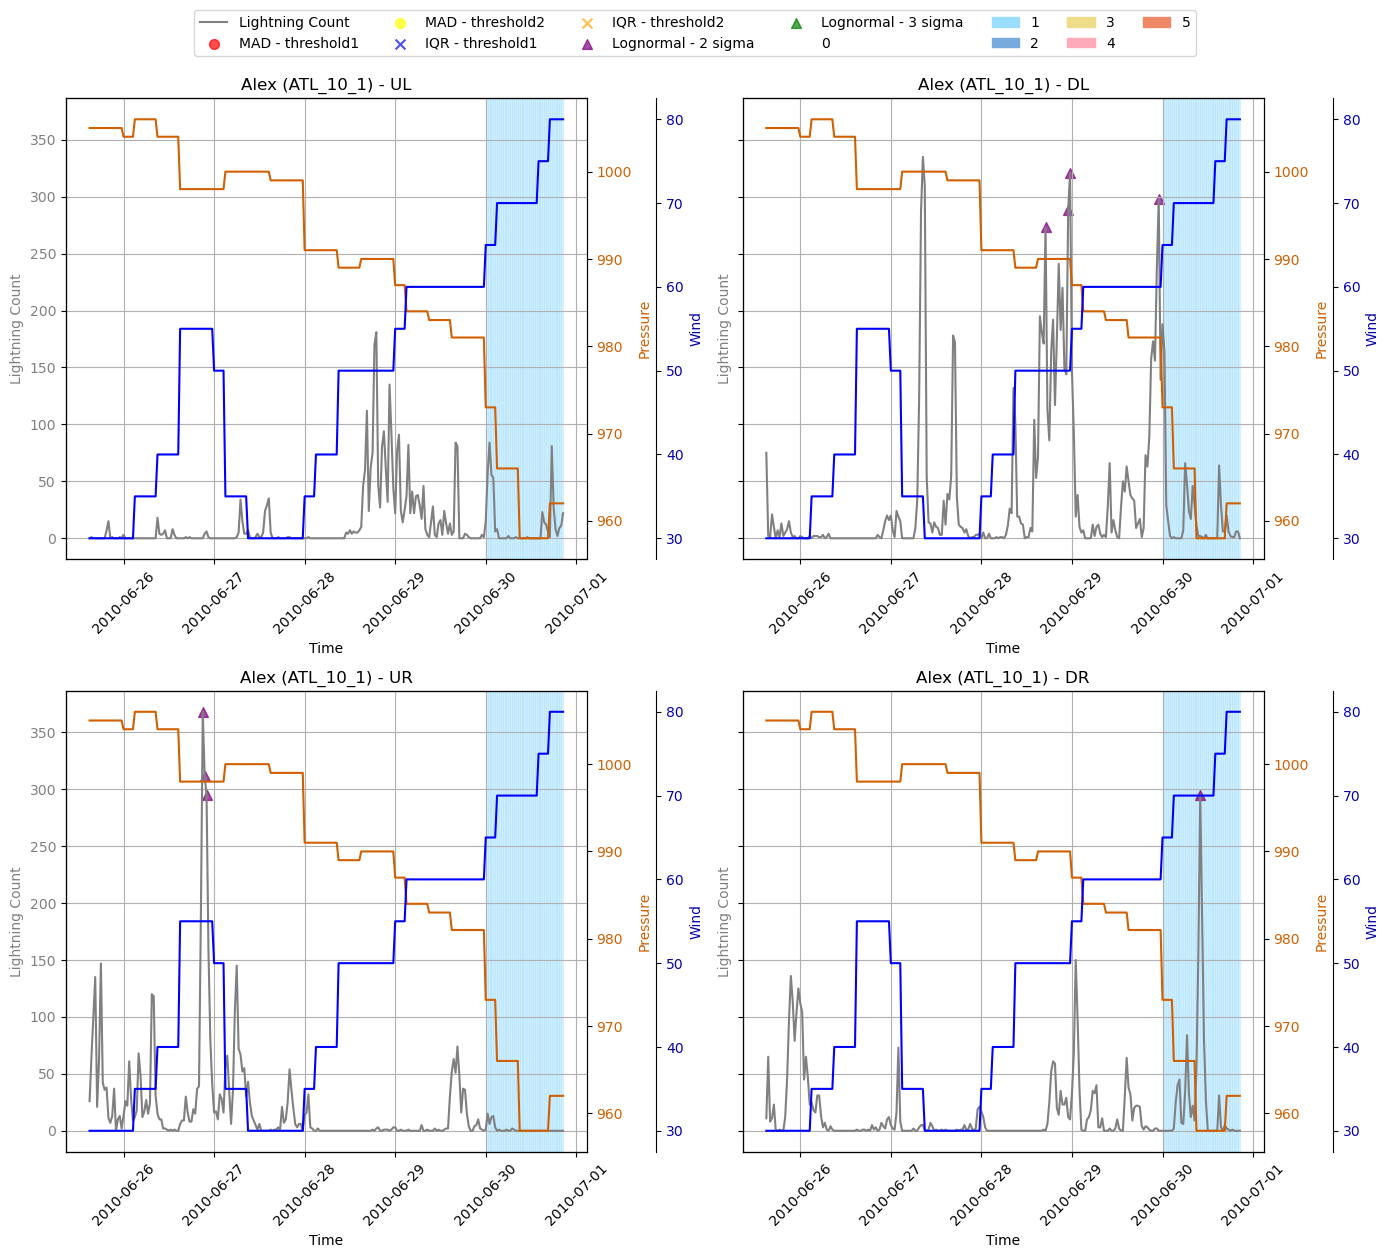

In [ ]:
# ATL_10_1 by shear quadrants
plot_tc_quadrants(cyclone_id, bursts, storm_names, rainband_data, "i3")
plot_tc_quadrants(cyclone_id, bursts, storm_names, rainband_data, "c5")

<Figure size 1000x500 with 0 Axes>

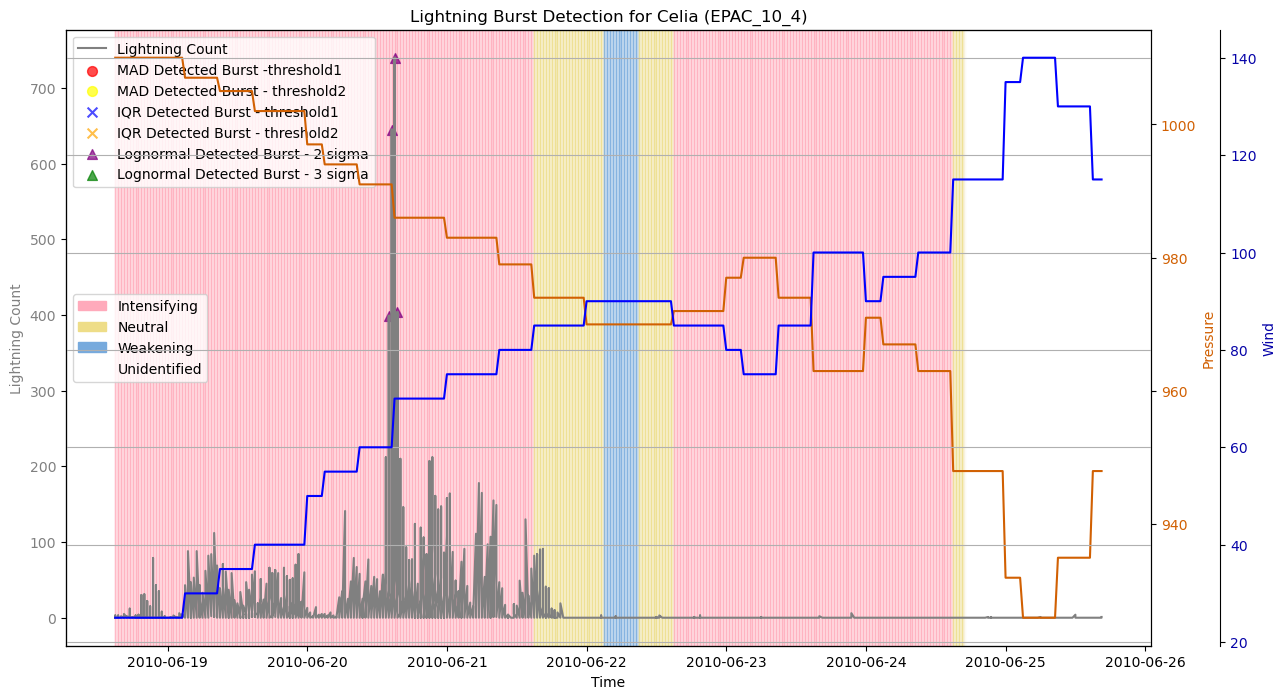

<Figure size 1000x500 with 0 Axes>

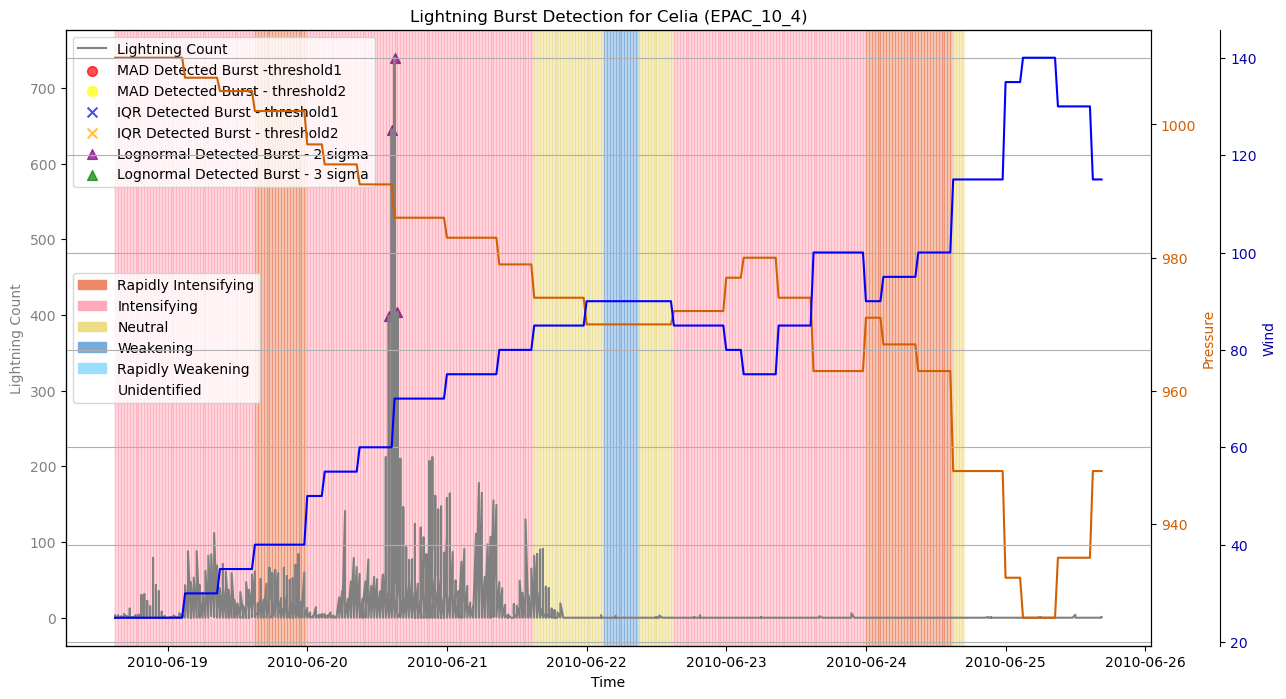

<Figure size 1000x500 with 0 Axes>

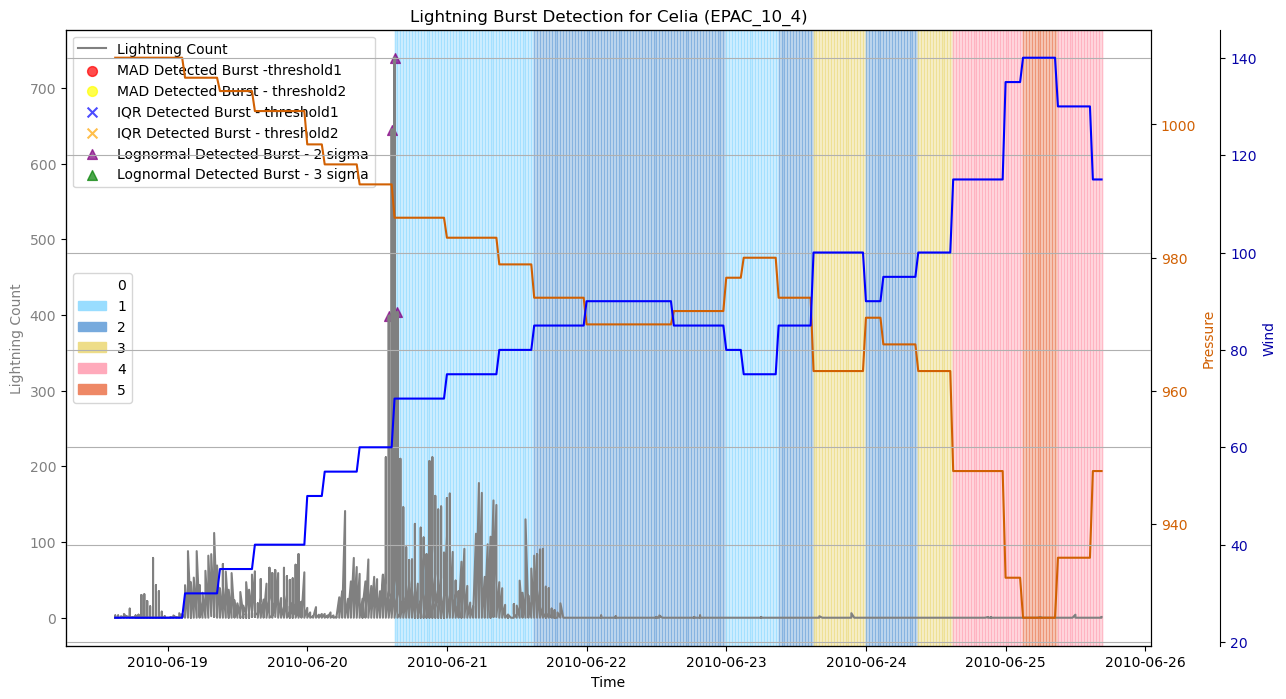

storm_code storm_name  mad1_bursts  mad2_bursts  mad1_threshold  \
101  EPAC_10_4      Celia            0            0        8.020353   

     mad2_threshold  iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  \
101        9.241567            0            0        6.768781        8.114402   

     ...  logn2_bursts  logn1_threshold  logn2_threshold  total_bins  \
101  ...             0          5.89286         7.389035         229   

     mad1_prop  mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
101        0.0        0.0        0.0        0.0        1.75         0.0  

[1 rows x 21 columns]

In [ ]:
# EPAC_10_4 - Celia
cyclone_id = 'EPAC_10_4'
plot_tc(cyclone_id, bursts, storm_names, rainband_data, "i3")
plot_tc(cyclone_id, bursts, storm_names, rainband_data, "i5")
plot_tc(cyclone_id, bursts, storm_names, rainband_data, "c5")
# Print the summary for this storm
tc_summary[tc_summary["storm_code"] == cyclone_id]

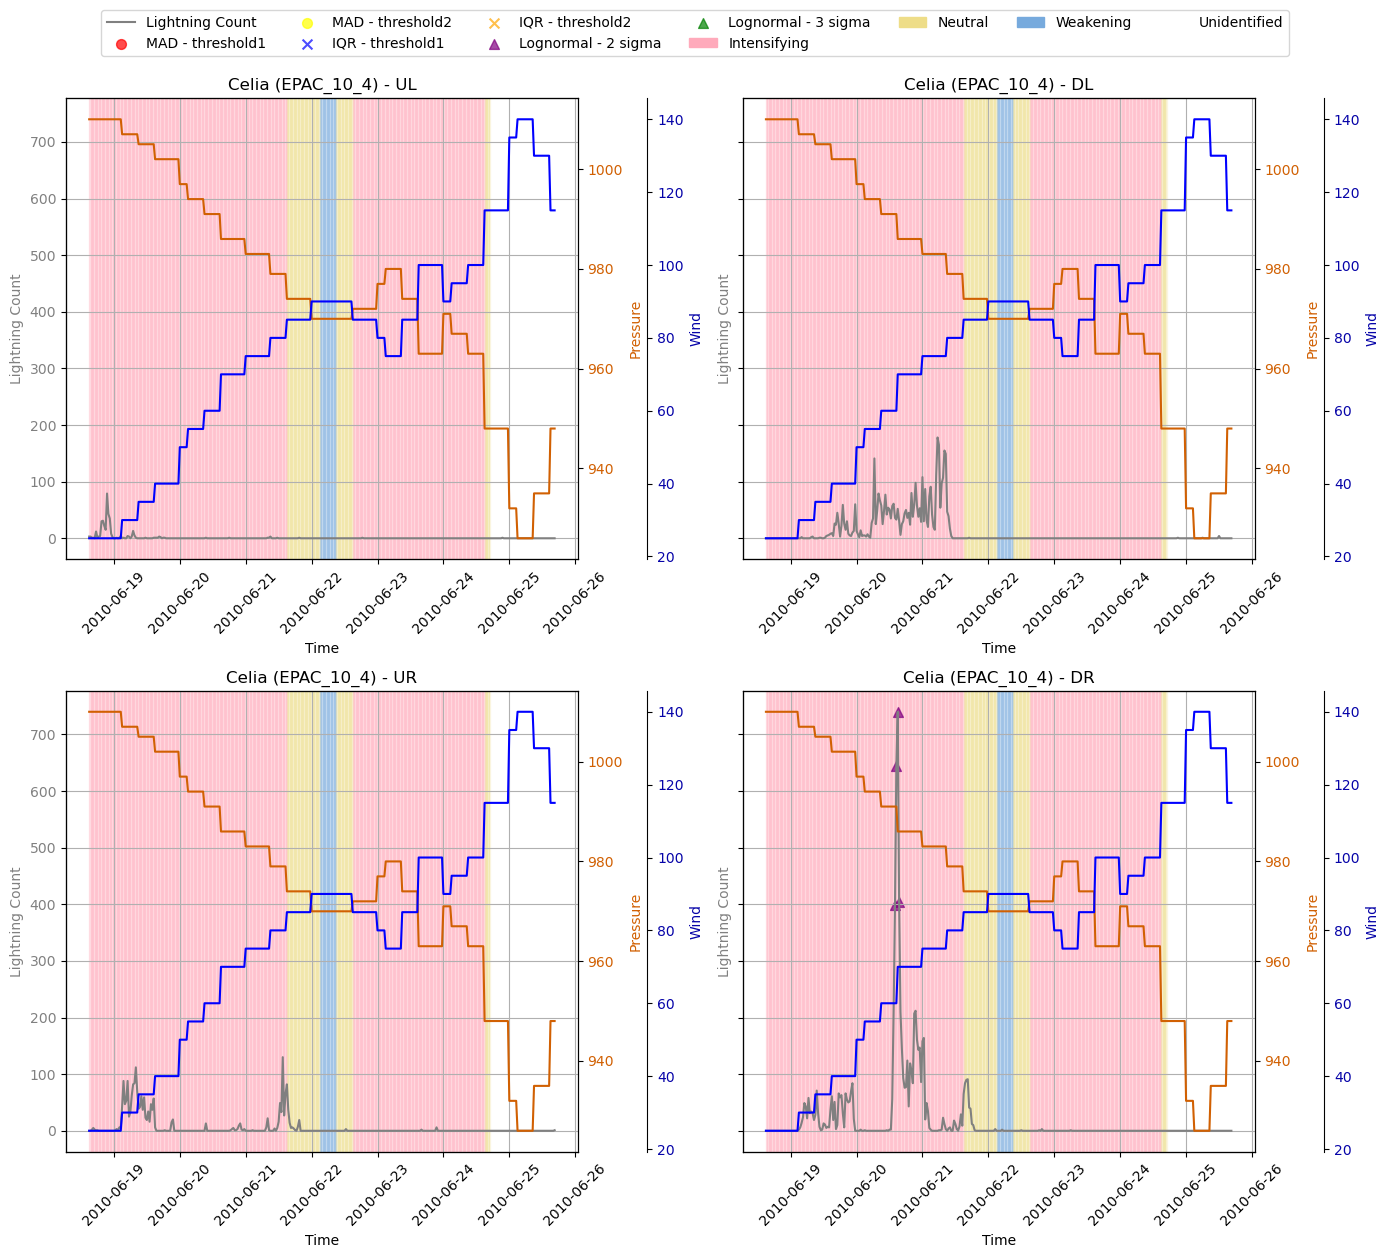

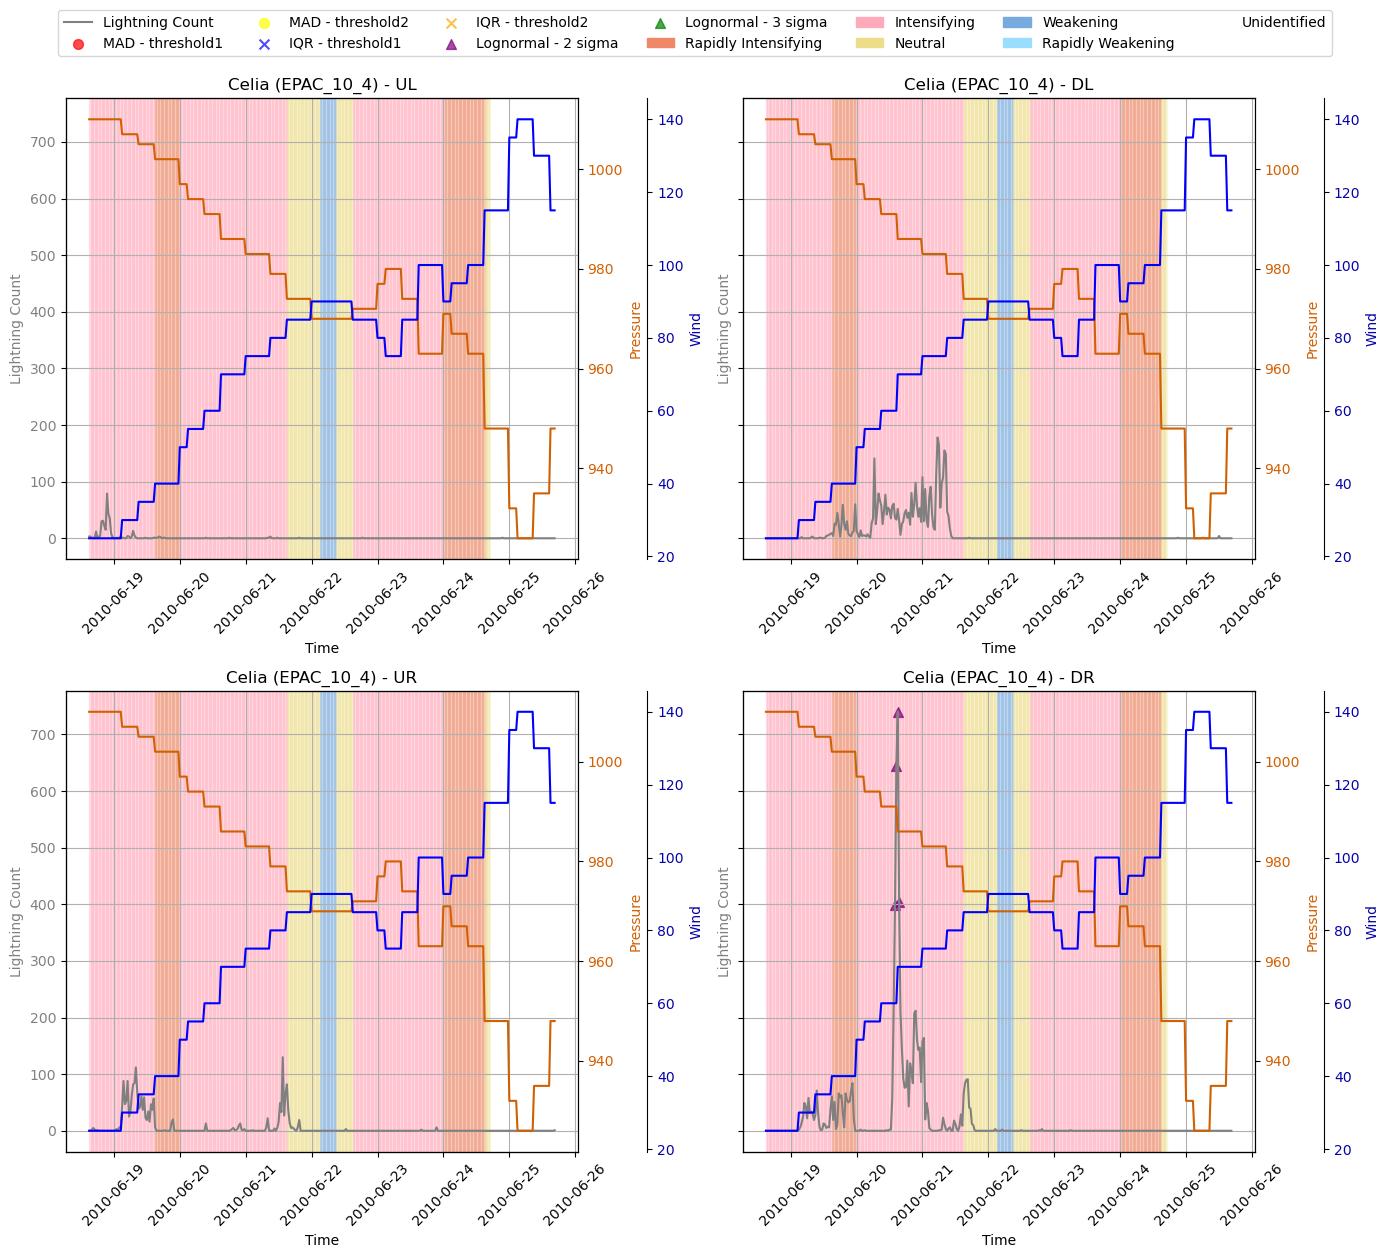

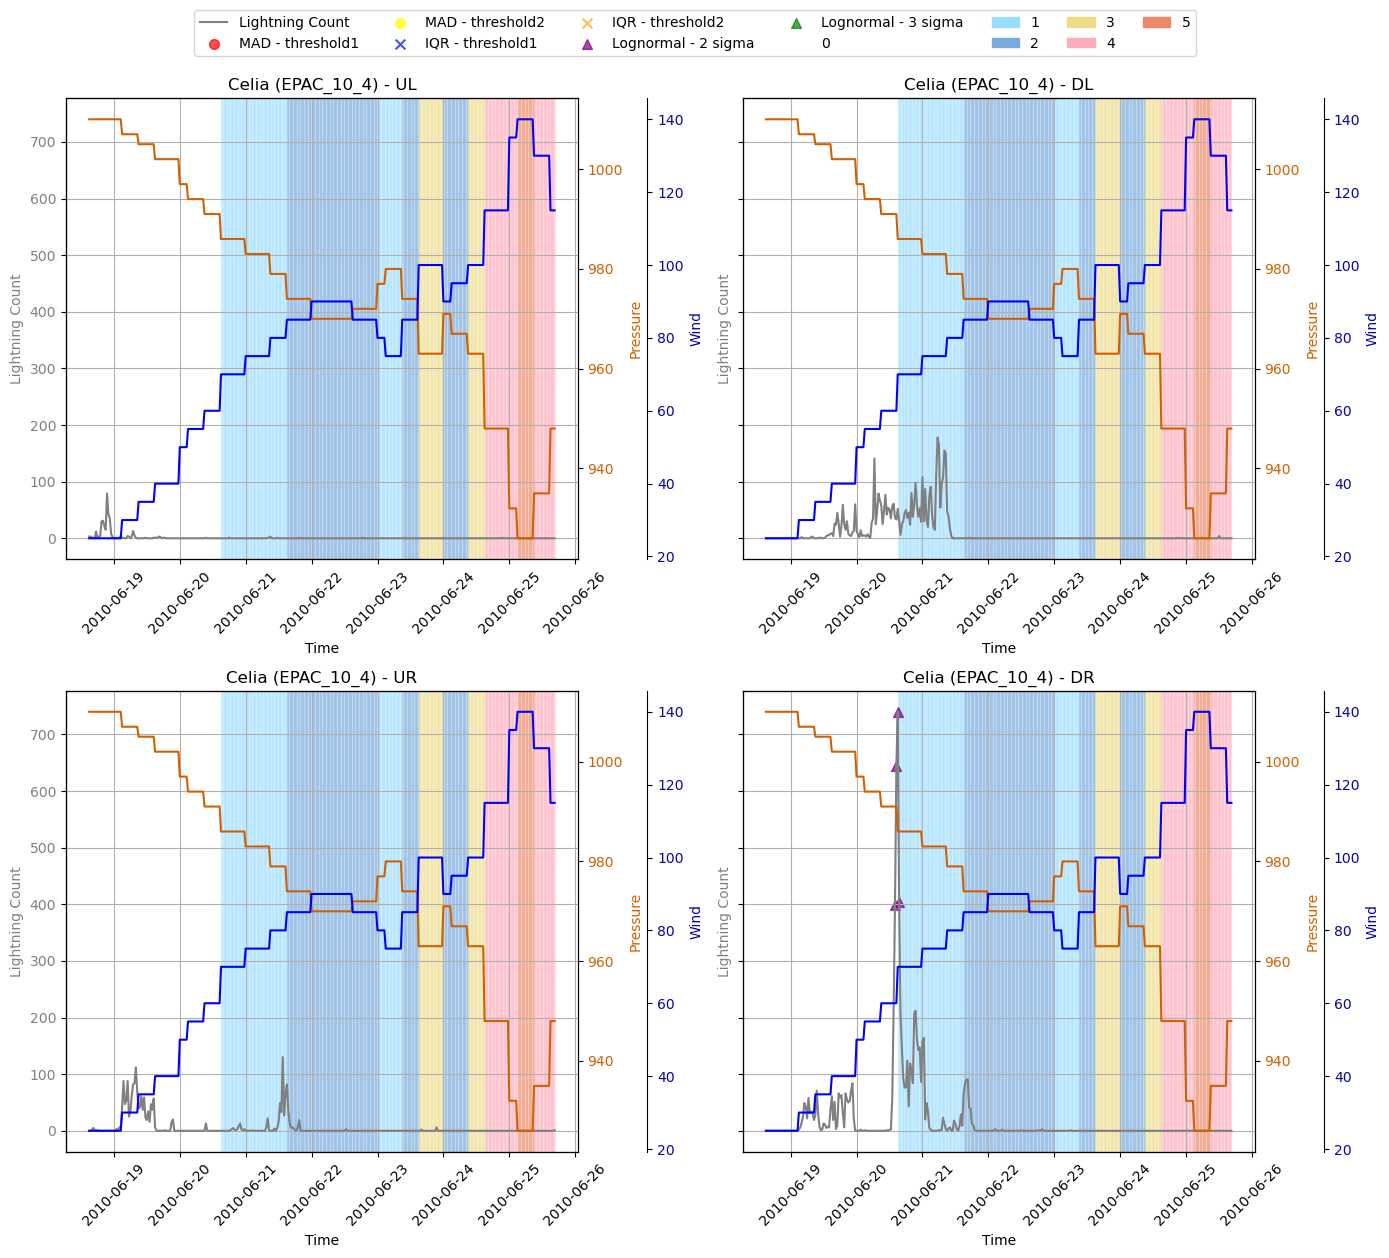

In [ ]:
# EPAC_10_4 by shear quadrants
plot_tc_quadrants(cyclone_id, bursts, storm_names, rainband_data, "i3")
plot_tc_quadrants(cyclone_id, bursts, storm_names, rainband_data, "i5")
plot_tc_quadrants(cyclone_id, bursts, storm_names, rainband_data, "c5")

<Figure size 1000x500 with 0 Axes>

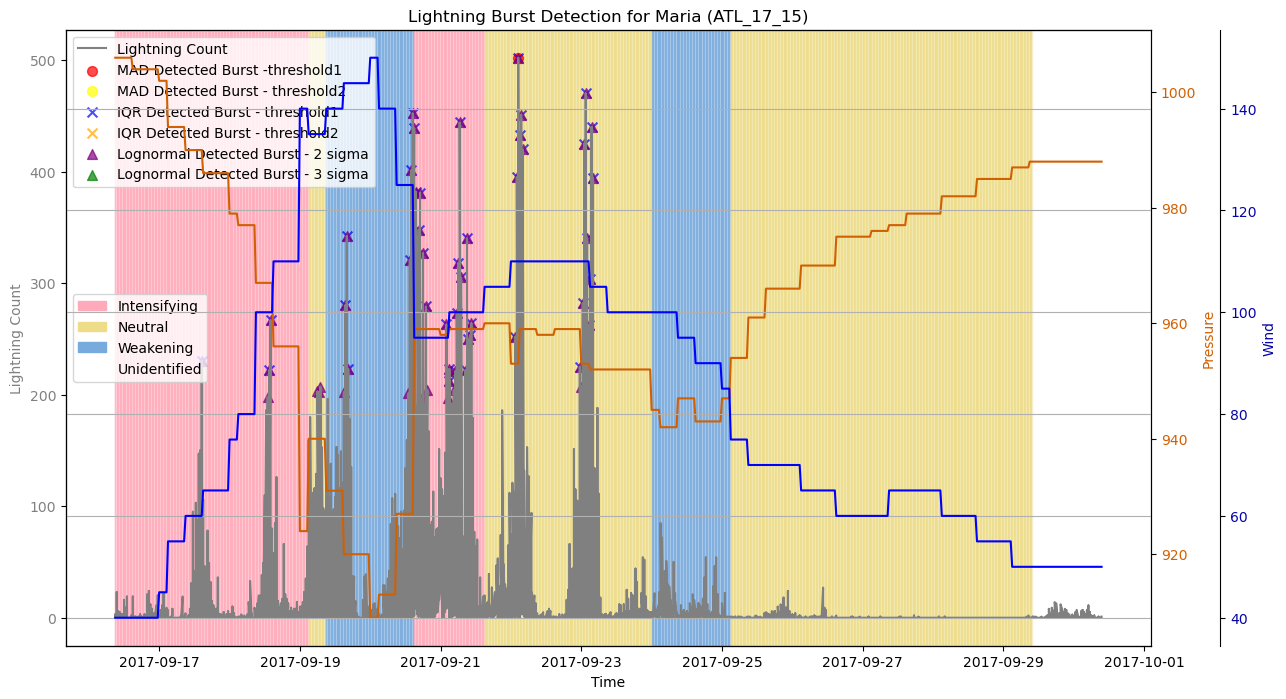

<Figure size 1000x500 with 0 Axes>

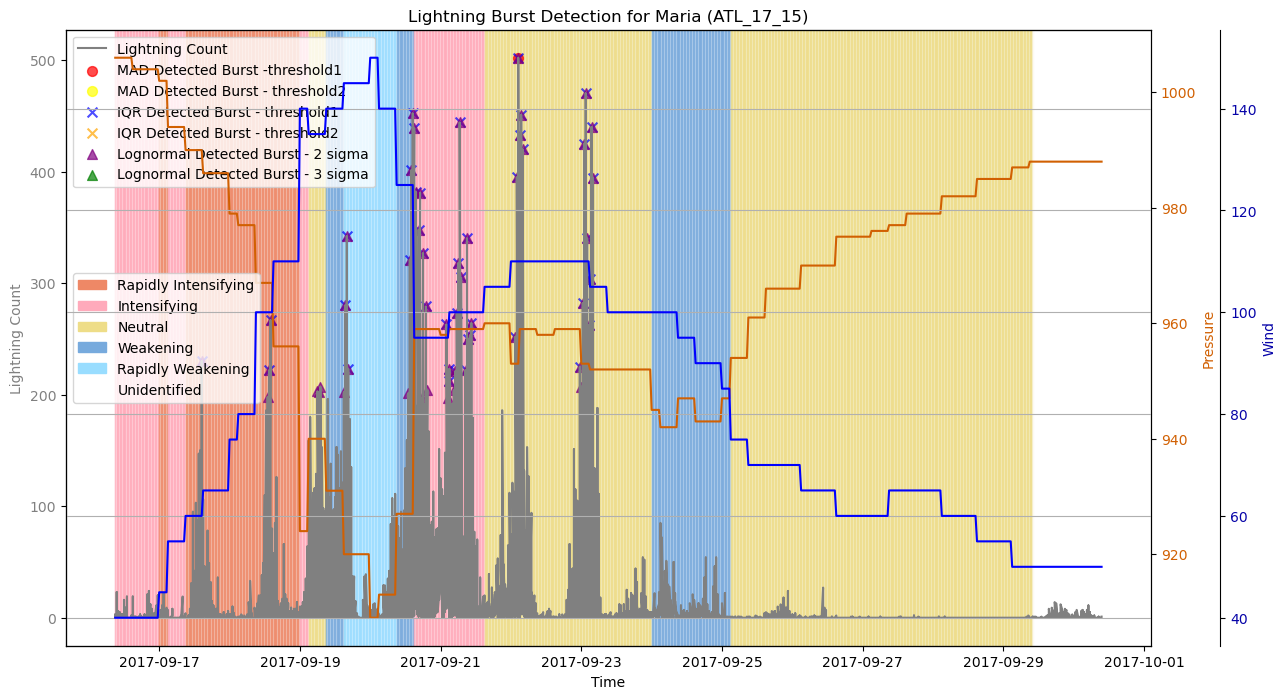

<Figure size 1000x500 with 0 Axes>

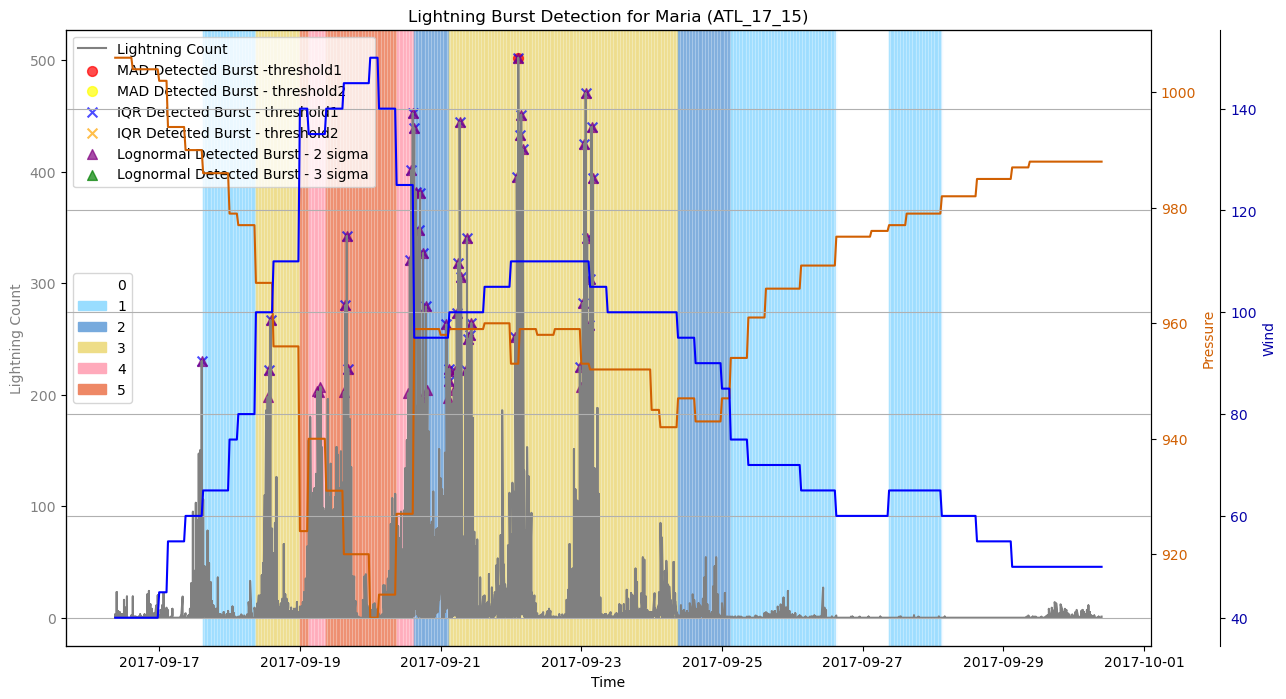

storm_code storm_name  mad1_bursts  mad2_bursts  mad1_threshold  \
249  ATL_17_15      Maria            1            0        6.186209   

     mad2_threshold  iqr1_bursts  iqr2_bursts  iqr1_threshold  iqr2_threshold  \
249        7.284821           43            0        5.339139        6.399271   

     ...  logn2_bursts  logn1_threshold  logn2_threshold  total_bins  \
249  ...             0         5.283362         6.780531        1045   

     mad1_prop  mad2_prop  iqr1_prop  iqr2_prop  logn1_prop  logn2_prop  
249        0.1        0.0       4.11        0.0        5.17         0.0  

[1 rows x 21 columns]

In [ ]:
# ATL_17_15 - Maria
cyclone_id = 'ATL_17_15'
plot_tc(cyclone_id, bursts, storm_names, rainband_data, "i3")
plot_tc(cyclone_id, bursts, storm_names, rainband_data, "i5")
plot_tc(cyclone_id, bursts, storm_names, rainband_data, "c5")
# Print the summary for this storm
tc_summary[tc_summary["storm_code"] == cyclone_id]

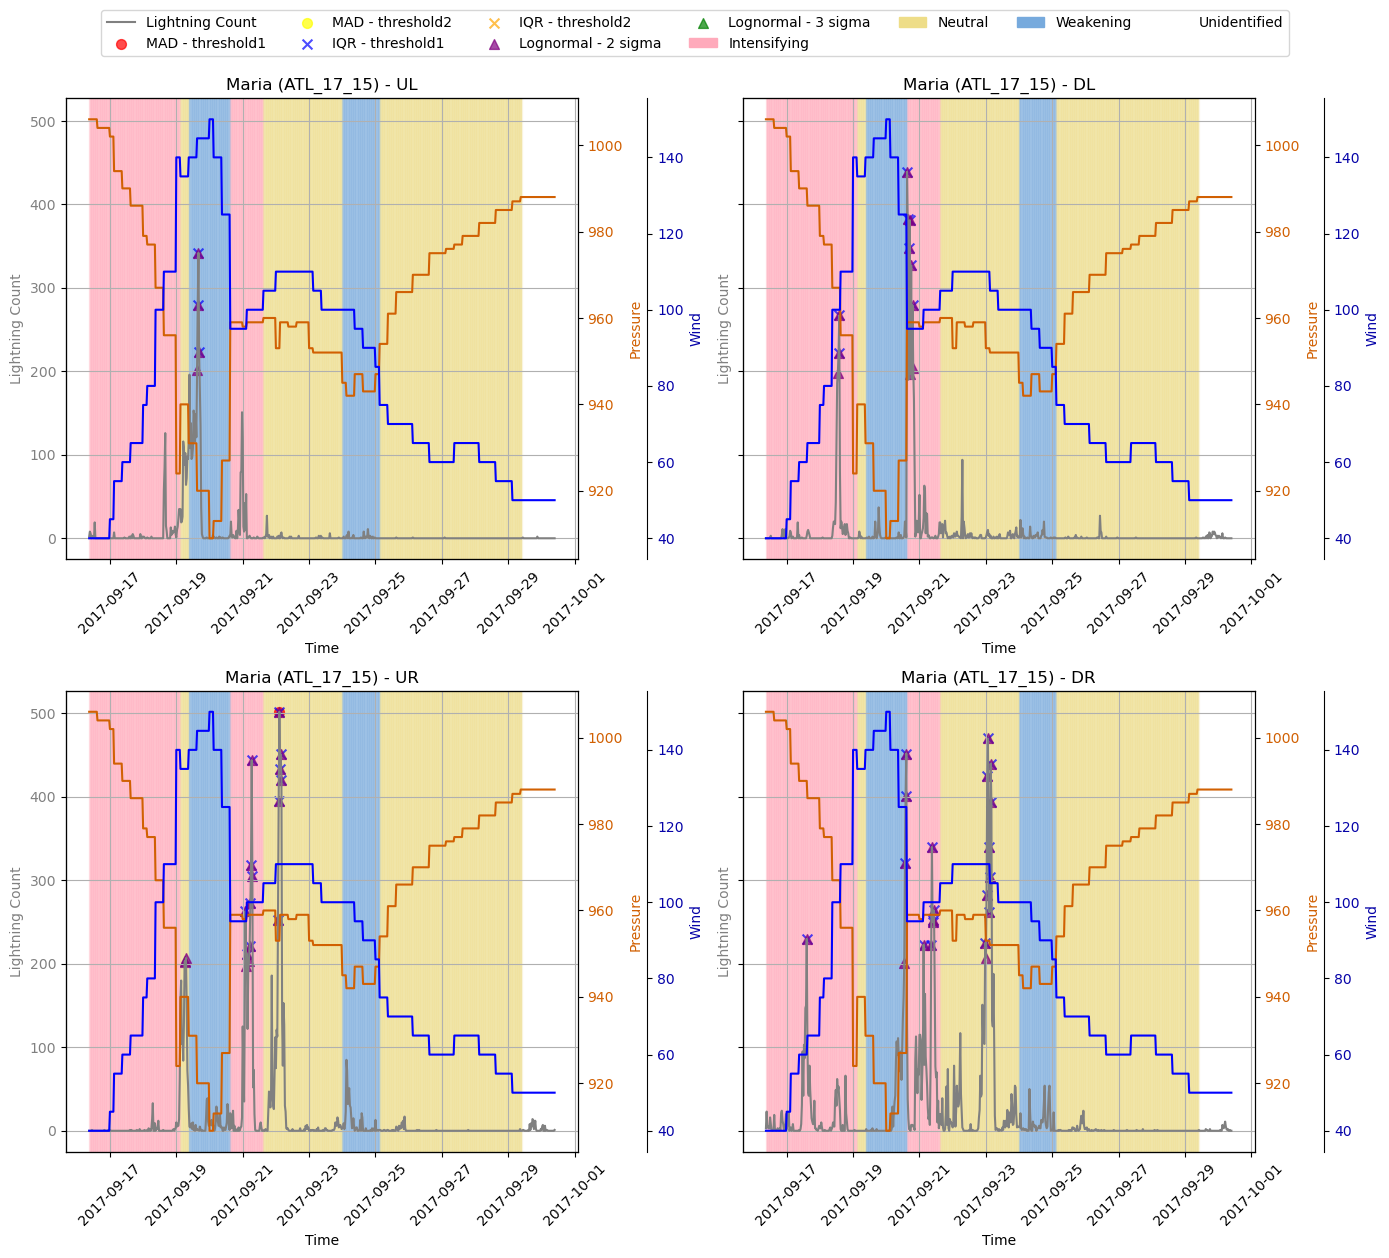

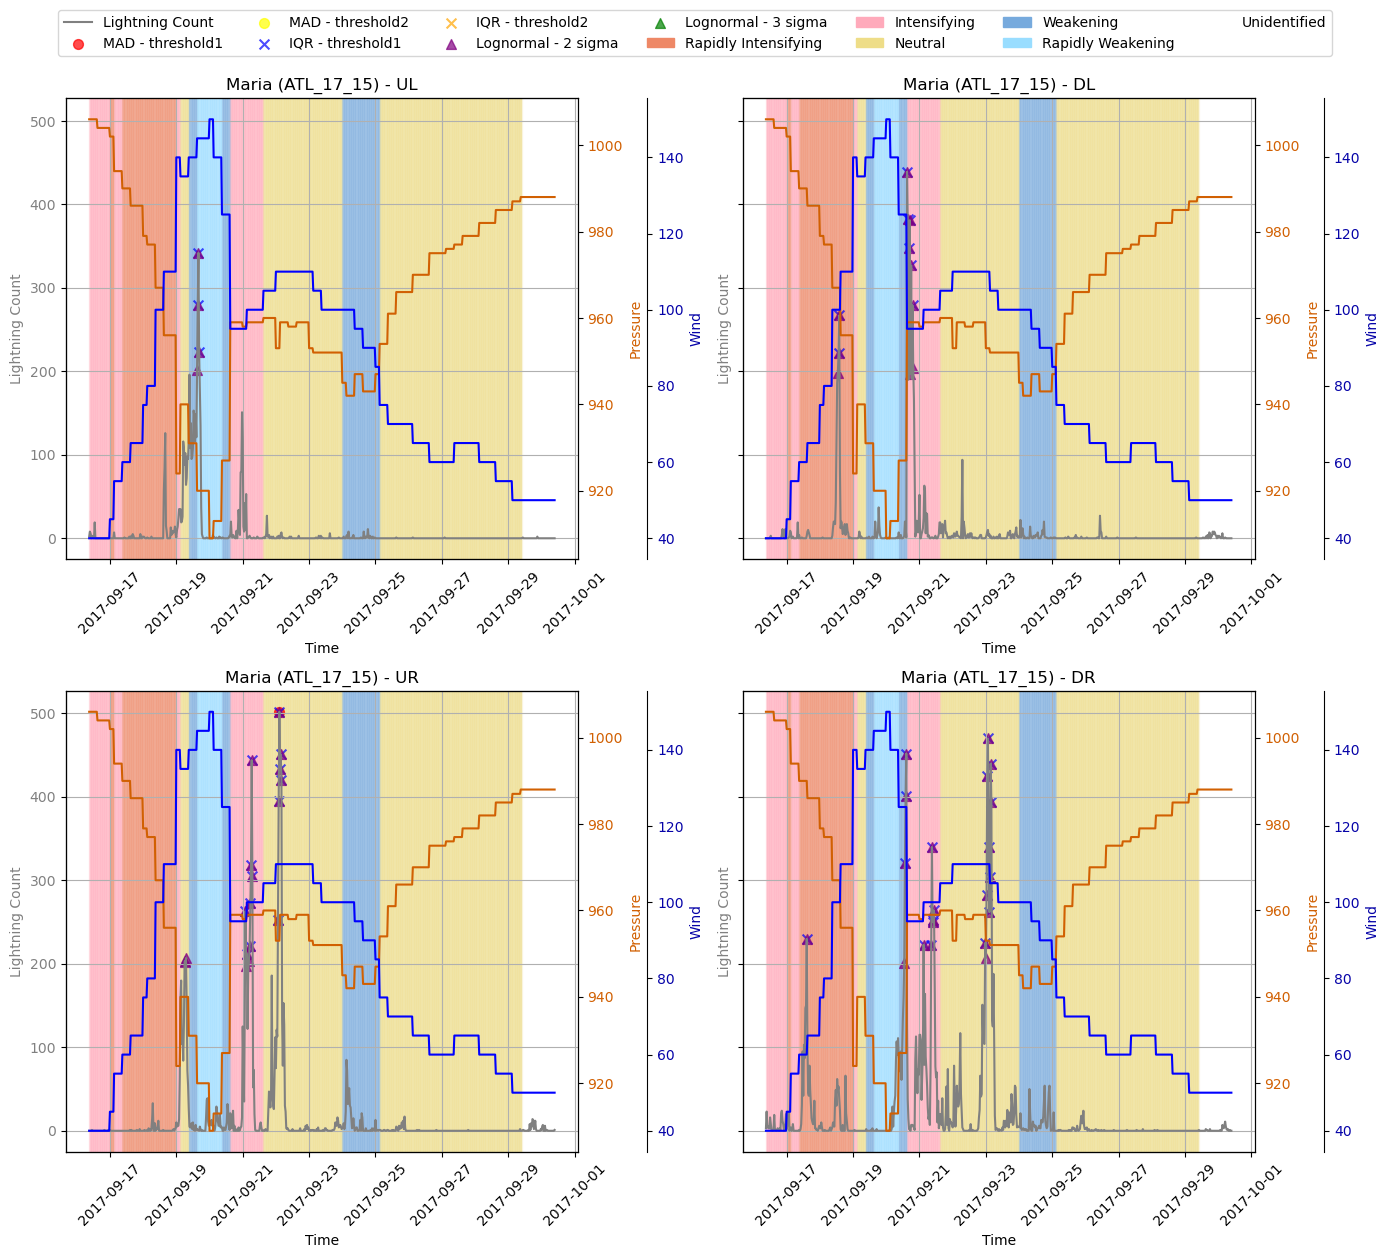

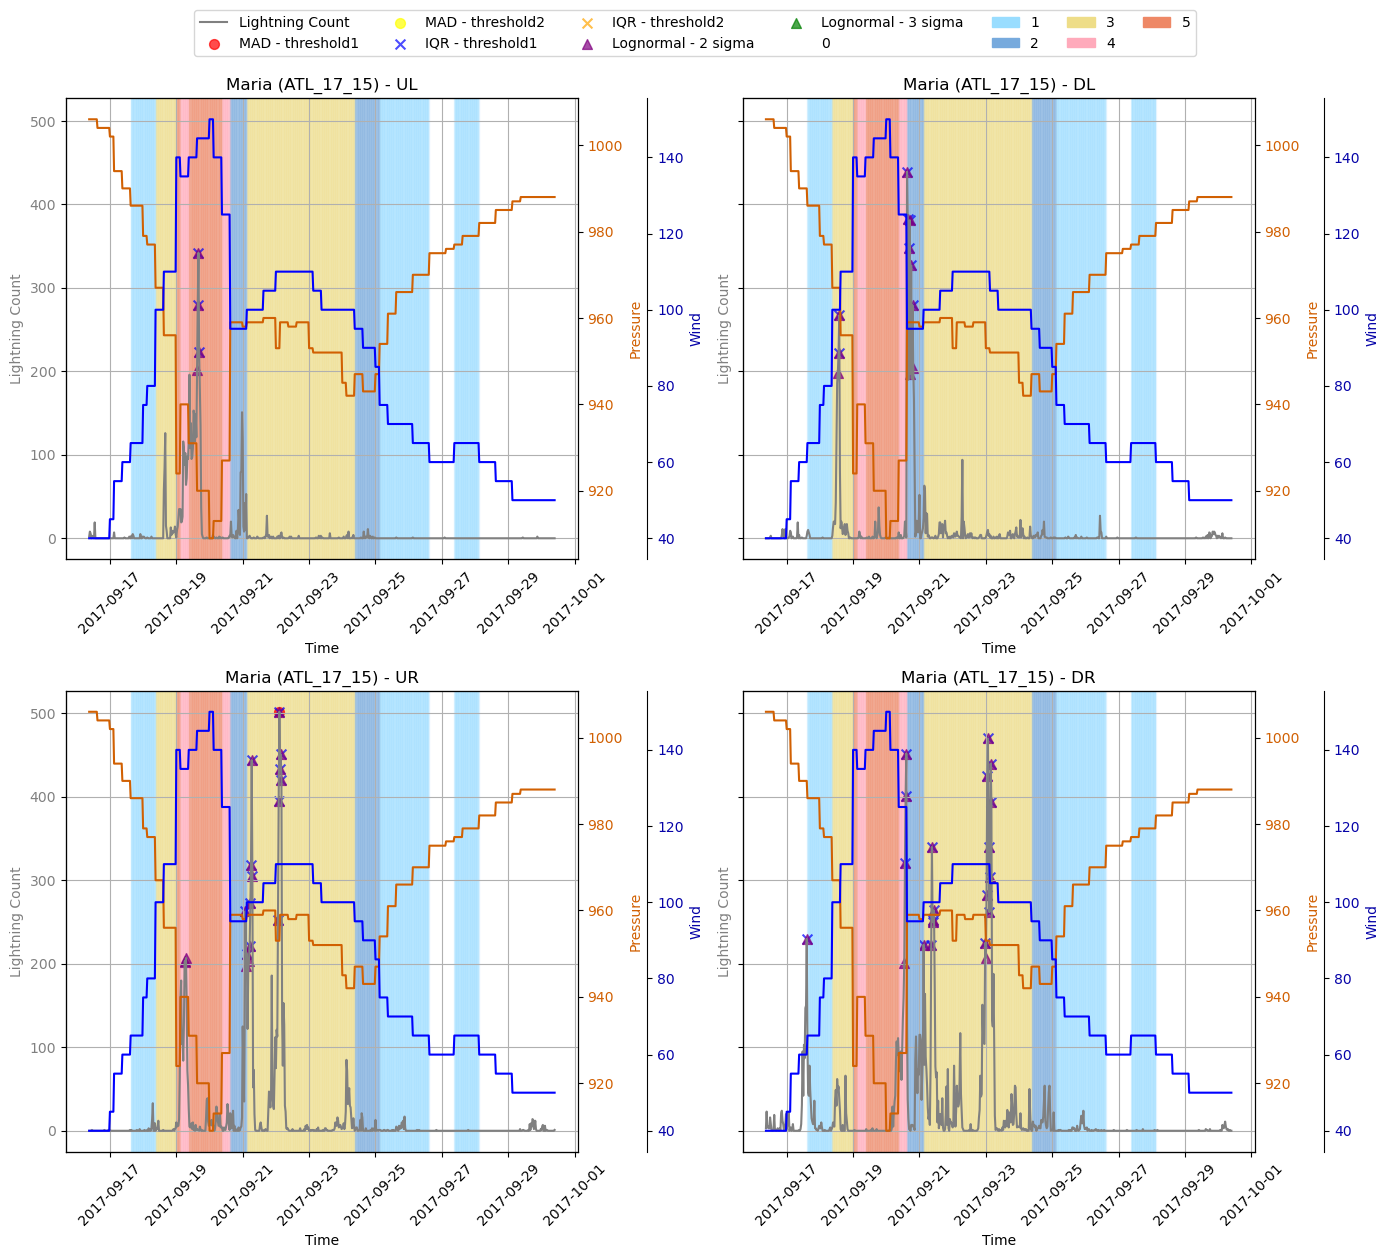

In [ ]:
# ATL_17_15 by shear quadrants
plot_tc_quadrants(cyclone_id, bursts, storm_names, rainband_data, "i3")
plot_tc_quadrants(cyclone_id, bursts, storm_names, rainband_data, "i5")
plot_tc_quadrants(cyclone_id, bursts, storm_names, rainband_data, "c5")

In [ ]:
# Export for external tool vis
rainband_data.write_csv("../analysis_data/rainband_lightning_data.csv")
tc_summary.to_csv("../analysis_data/rainband_threshold_summary.csv", index=False)
bursts.to_csv("../analysis_data/rainband_bursts.csv", index=False)

In [ ]:
# Define threshold names for use later
threshold_names = {
    'mad1':['mad1_threshold','MAD1'],
    'mad2':['mad2_threshold','MAD2'],
    'iqr1':['iqr1_threshold','IQR1'],
    'iqr2':['iqr2_threshold','IQR2'],
    'logn1':['logn1_threshold','Lognormal 2 Sigma'],
    'logn2':['logn2_threshold','Lognormal 3 Sigma'],
}
threshold_keys = list(threshold_names.keys())
threshold_cols = [threshold_names[key][0] for key in threshold_keys]
threshold_labels = [threshold_names[key][1] for key in threshold_keys]

In [ ]:
# No bursts detected
# marker - need to look into why the agg result dataframes are not the same length??
selected_columns = ["mad1_bursts", "mad2_bursts", "iqr1_bursts", "iqr2_bursts", "logn1_bursts", "logn2_bursts"]
print(f"{(tc_summary_w_0[selected_columns].sum(axis=1) == 0).sum()} TCs of {len(tc_summary_w_0)} TCs with no bursts detected across all 6 threshold methods for analysis including 0 count timebins.")
no_bursts = tc_summary[tc_summary[selected_columns].sum(axis=1) == 0]
print(f"{len(no_bursts)} TCs of {len(tc_summary)} TCs with no bursts detected across all 6 threshold methods for analysis without 0 count timebins.")

1 TCs of 303 TCs with no bursts detected across all 6 threshold methods for analysis including 0 count timebins.
22 TCs of 303 TCs with no bursts detected across all 6 threshold methods for analysis without 0 count timebins.
